In [1]:
!pip install scikit-optimize

Based on this: 

*  https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py

In [2]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import Optimizer

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skopt import gp_minimize
import numpy as np
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

In [3]:
noise_level = 0.1

# Our 1D toy problem, this is the function we are trying to
# minimize

def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

def objective_wo_noise(x):
    return objective(x, noise_level=0)

In [4]:
opt_gp = Optimizer([(-2.0, 2.0)], base_estimator="GP", n_initial_points=5,
                acq_optimizer="sampling", random_state=42)

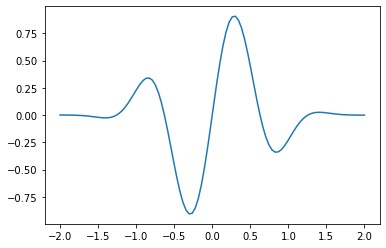

In [5]:
# let's do this by hand first...


X = np.linspace(-2, 2, 100)
y = np.vectorize(lambda x: objective_wo_noise([x]))(X)
plt.plot(X, y)

In [6]:
# Generate data and fit GP
rng = np.random.RandomState(4)
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
# take 5 points...
X = rng.uniform(-2, 2, 5)
X = np.sort(X)
y = np.vectorize(lambda x: objective_wo_noise([x]))(X)
gp.fit(X.reshape(-1, 1), y)

# how should we approach this? One curve?

GaussianProcessRegressor(alpha=0.0, kernel=Matern(length_scale=1, nu=2.5))

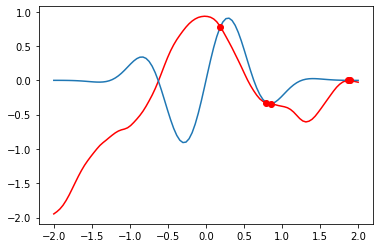

In [7]:
X_ = np.linspace(-2, 2, 100)
y_mean, y_std = gp.predict(X_.reshape(-1, 1), return_std=True)

y_samples = gp.sample_y(X_.reshape(-1, 1), 1)
plt.plot(X_, y_samples, 'r')
plt.plot(X_, np.vectorize(lambda x: objective_wo_noise([x]))(X_))
plt.plot(X, y, 'ro')

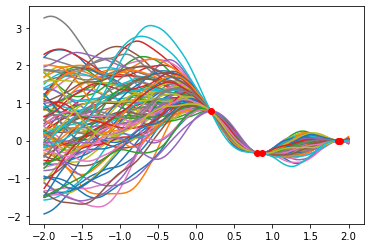

In [8]:
# if we add some noise...
X_ = np.linspace(-2, 2, 100)
y_mean, y_std = gp.predict(X_.reshape(-1, 1), return_std=True)

y_samples = gp.sample_y(X_.reshape(-1, 1), 100)
plt.plot(X_, y_samples)
# plt.plot(X_, np.vectorize(lambda x: objective_wo_noise([x]))(X_))
plt.plot(X, y, 'ro')

How do we pick the next point to evaluate?


From here there are several way to pick the next point. Two common approaches are around:

*    Upper confidence bound (exploration vs exploitation)
*    Expected improvement



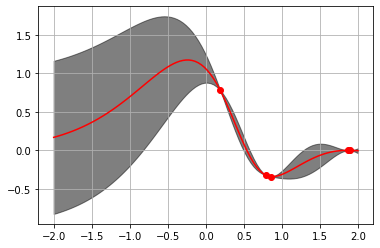

In [9]:
plt.plot(X_, y_mean, 'r', X, y, 'ro')
plt.grid(True)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.5, color='k')

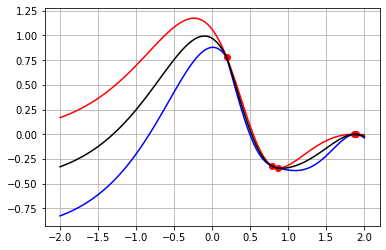

In [10]:
# for example, let's just consider the lower bound
# kappa controls the exploration/exploitation.
kappa = 0.5
plt.plot(X_, y_mean, 'r', X, y, 'ro', X_, y_mean - y_std, 'b', X_, y_mean - kappa*y_std, 'k')
plt.grid(True)

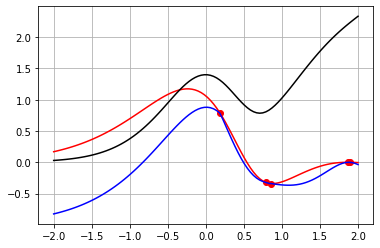

In [11]:
# expected improvement
from scipy.stats import norm
best_y = np.min(y)
z = (y_mean - best_y + X_)/y_std
ei = (y_mean - best_y+X_)*norm.cdf(z) + y_std*norm.pdf(z)
plt.plot(X_, y_mean, 'r', X, y, 'ro', X_, y_mean - y_std, 'b', X_, ei, 'k')
plt.grid(True)

Let's use scikit optimise instead...

In [12]:
res = gp_minimize(objective_wo_noise, # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=10,         # the number of evaluations of f
                  n_random_starts=1,  # the number of random initialization points
                  x0 = [[x] for x in X],
                  random_state=1234)  # the random seed

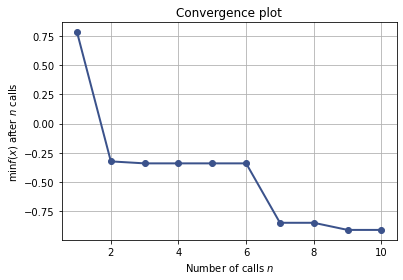

In [13]:
from skopt.plots import plot_convergence
plot_convergence(res);

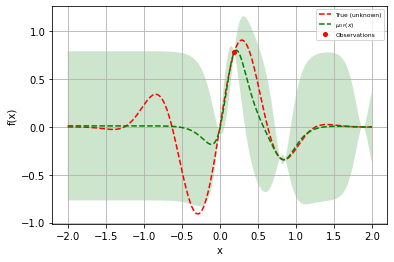

In [17]:
plot_gaussian_process(res, n_calls=0,
                      objective=objective_wo_noise,
                      show_title=False)

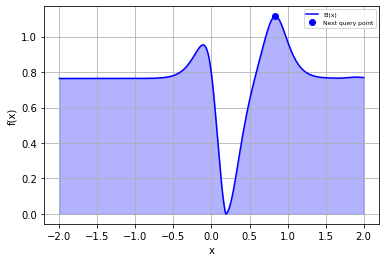

In [18]:
plot_gaussian_process(res, n_calls=0,
                           show_legend=True, show_title=False,
                           show_mu=False, show_acq_func=True,
                           show_observations=False,
                           show_next_point=True)

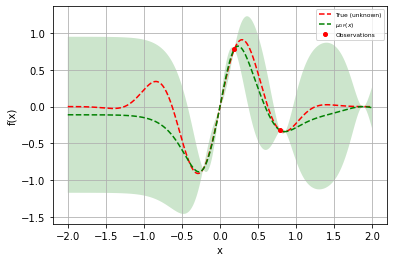

In [19]:
plot_gaussian_process(res, n_calls=1,
                      objective=objective_wo_noise,
                      show_title=False)

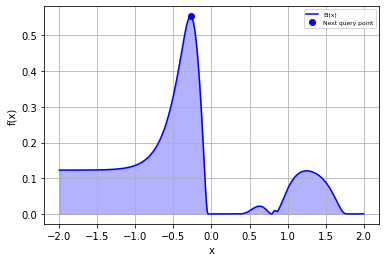

In [20]:
plot_gaussian_process(res, n_calls=1,
                           show_legend=True, show_title=False,
                           show_mu=False, show_acq_func=True,
                           show_observations=False,
                           show_next_point=True)

In [23]:
plt.figure

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

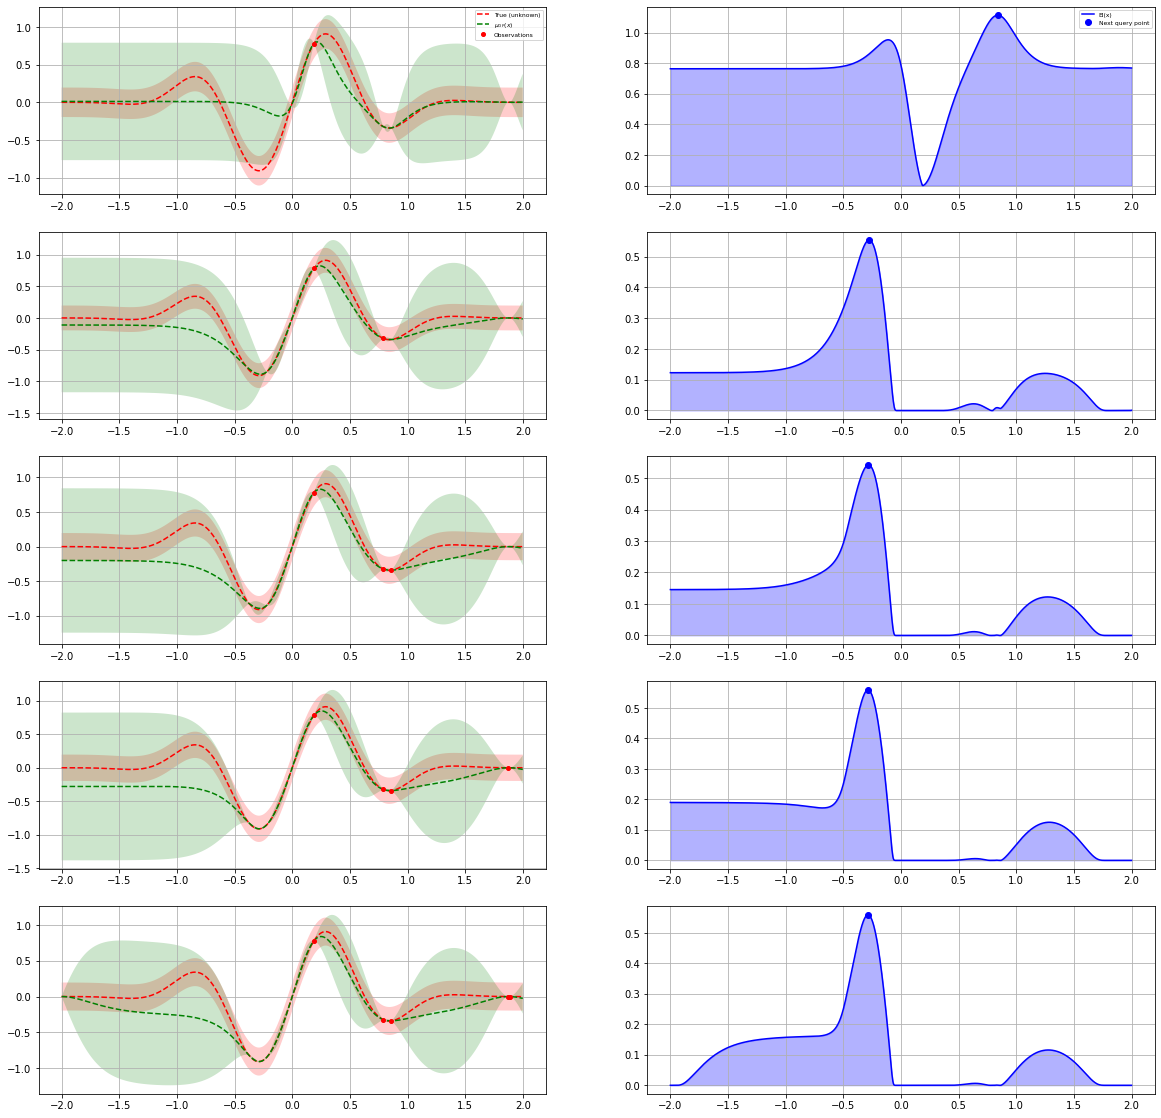

In [28]:
plt.figure(figsize=(20,20))
for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=objective_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()